# Bank Marketing XGBoost Baseline (Playground S5E8)

## Introduction

In this notebook, we tackle the [Kaggle Playground Series – Season 5, Episode 8](https://www.kaggle.com/competitions/playground-series-s5e8), which is based on a version of the classic **UCI Bank Marketing dataset**. The goal is to build a machine learning model that predicts whether a customer will open a new bank account (`y = 1`) given demographic details, financial status, and information about previous marketing contacts.

Our workflow includes:
- **Exploratory Data Analysis (EDA):** understanding class balance, missing values, and key feature distributions.
- **Feature Engineering:** transformations for calendar fields (`day`, `month`), log-scaling skewed variables (`balance`, `duration`, `campaign`, `pdays`), and handling categorical features (e.g., `job`, `marital`, `education`).
- **Modeling:** training gradient boosted trees (XGBoost with GPU acceleration), tuned via Optuna for maximum AUC.
- **Validation Strategy:** stratified K-fold cross-validation to ensure reliable estimates given the class imbalance (~12% positive rate).
- **Results & Submission:** generating predictions for the competition test set and preparing a `submission.csv`.

A key note: the feature `duration` (length of the call) is highly predictive but represents **data leakage** in a real-world deployment, since it is only known after the marketing call is completed. In this notebook, we keep `duration` for leaderboard benchmarking, but also show engineered alternatives (`log_duration`, duration bins) to test robustness.


# Table of Contents

1. [Introduction](#Introduction)  
2. [Data Loading and Overview](#Data-Loading-and-Overview)  
3. [Exploratory Data Analysis](#Exploratory-Data-Analysis)  
4. [Feature Engineering](#Feature-Engineering)
5. [Build and Train the Model](#Build-and-Train-the-Model)
6. [Validation Strategy](#Validation-Strategy)  
7. [Hyperparameter Tuning with Optuna](#Hyperparameter-Tuning-with-Optuna)  
8. [Final Model Training](#Final-Model-Training)
9. [Test Using Original Dataset](#Test-Using-Original-Dataset)
10. [Submission Preview](#Submission-Preview)  
11. [Results and Conclusions](#Results-and-Conclusions)  


**Highlights**
- XGBoost with Optuna hyperparameter tuning (AUC-focused).
- Robust validation: stratified K-fold + early stopping.
- Clear feature engineering for balance/campaign/pdays + calendar features.

## Data Loading and Overview

In [1]:
# Install necessary components
!pip -q install optuna xgboost matplotlib plotly
!pip install optuna-integration[lightgbm]


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import random 
import warnings  # Provides a way to control the display of warning messages (e.g., filter out deprecation warnings)
from IPython.display import display  # for nicer display in notebooks
from pandas.api.types import is_categorical_dtype
import optuna
import optuna.visualization as ov
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Define some awesome utilities, from C4rl05/V on kaggle
def configure_notebook(seed=548, float_precision=3, max_columns=15, max_rows=25):
    """
    Configure notebook settings:
      - Disables warnings for cleaner output.
      - Sets pandas display options for better table formatting.
      - Returns a seed value for reproducibility.
    
    Parameters:
      seed (int): Random seed (default 548).
      float_precision (int): Number of decimal places for floats (default 3).
      max_columns (int): Maximum number of columns to display (default 15).
      max_rows (int): Maximum number of rows to display (default 25).

    Returns:
      int: The provided seed.
    """
    # Disable all warnings
    warnings.filterwarnings("ignore")
    
    # Set pandas display options for nicer output
    pd.options.display.float_format = f"{{:,.{float_precision}f}}".format
    pd.set_option("display.max_columns", max_columns)
    pd.set_option("display.max_rows", max_rows)

    # Set seeds for reproducibility in numpy and the standard random module
    np.random.seed(seed)
    random.seed(seed)
    
    return seed

# Apply configuration and set random seeds for reproducibility
seed = configure_notebook()    

In [4]:
# Configurable flag to control whether GPU is used
USE_GPU = True

In [5]:
def eda_summary(df):
    # 1. Display the first few rows
    print("======== First 5 Rows ========")
    display(df.head().T)
    
    # 2. DataFrame information (data types, non-null counts, etc.)
    print("\n======== DataFrame Info ========")
    df.info()
    
    # 3. Descriptive statistics for numeric columns
    print("\n======== Descriptive Statistics (Numeric Columns) ========")
    display(df.describe())
    
    # 4. Descriptive statistics for categorical columns (if any)
    categorical_df = df.select_dtypes(include=['object', 'category'])
    print("\n======== Descriptive Statistics (Categorical Columns) ========")
    if not categorical_df.empty:
        display(categorical_df.describe())
    else:
        print("No categorical columns found.")
    
    # 5. Missing values summary
    print("\n======== Missing Values Summary ========")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_summary = pd.DataFrame({
        "Missing Count": missing,
        "Percentage": missing_percent
    })
    display(missing_summary)
    
    # 6. Count of duplicated rows
    print("\n======== Duplicated Rows ========")
    print(f"Total duplicated rows: {df.duplicated().sum()}")
    
    # 7. Count of each data type
    print("\n======== Data Types Count ========")
    display(df.dtypes.value_counts())
    
    # 8. Correlation matrix for numeric variables (if more than one exists)
    numeric_cols = df.select_dtypes(include=[np.number])
    if numeric_cols.shape[1] > 1:
        print("\n======== Correlation Matrix (Numeric Columns) ========")
        display(numeric_cols.corr())
    else:
        print("\n======== Correlation Matrix ========")
        print("Not enough numeric columns to compute correlation.")
    
    # 9. Value counts for categorical variables with low cardinality
    print("\n======== Value Counts for Categorical Columns (Low Cardinality) ========")
    if not categorical_df.empty:
        for col in categorical_df.columns:
            if df[col].nunique() <= 20:
                print(f"\nValue Counts for '{col}':")
                display(df[col].value_counts())
    else:
        print("No categorical columns found.")


#### Read the training data and display a bit of it

In [6]:
PLAYGROUND_PATH = '/kaggle/input/playground-series-s5e8/'
PLAYGROUND_PATH = 'data/'

In [7]:
training_df = pd.read_csv(PLAYGROUND_PATH + 'train.csv')
training_df

,id,age,job,marital,education,default,balance,...,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,...,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,...,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,...,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,...,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,...,feb,902,1,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,29,services,single,secondary,no,1282,...,jul,1006,2,-1,0,unknown,1
749996,749996,69,retired,divorced,tertiary,no,631,...,aug,87,1,-1,0,unknown,0
749997,749997,50,blue-collar,married,secondary,no,217,...,apr,113,1,-1,0,unknown,0
749998,749998,32,technician,married,secondary,no,-274,...,aug,108,6,-1,0,unknown,0


#### Read the test data and display it

In [8]:
test_df = pd.read_csv(PLAYGROUND_PATH + 'test.csv')
test_df

,id,age,job,marital,education,default,balance,...,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,...,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,...,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,...,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,...,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,...,22,jul,181,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,43,management,married,tertiary,no,0,...,18,nov,65,2,-1,0,unknown
249996,999996,40,services,married,unknown,no,522,...,19,nov,531,1,189,1,failure
249997,999997,63,retired,married,primary,no,33,...,3,jul,178,1,92,8,success
249998,999998,50,blue-collar,married,primary,no,2629,...,30,may,163,2,-1,0,unknown


#### Get rid of the 'id' column before examining the data.  Also, it'll confuse training.

In [9]:
training_df.drop('id', axis=1, inplace=True)
training_df.head()

,age,job,marital,education,default,balance,housing,...,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,married,secondary,no,7,no,...,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,...,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,...,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,...,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,...,feb,902,1,-1,0,unknown,1


In [10]:
# Save a copy with the ID for use later
test_ids = test_df['id'].copy()

test_df.drop('id', axis=1, inplace=True)
test_df.head()

,age,job,marital,education,default,balance,housing,...,day,month,duration,campaign,pdays,previous,poutcome
0,32,blue-collar,married,secondary,no,1397,yes,...,21,may,224,1,-1,0,unknown
1,44,management,married,tertiary,no,23,yes,...,3,apr,586,2,-1,0,unknown
2,36,self-employed,married,primary,no,46,yes,...,13,may,111,2,-1,0,unknown
3,58,blue-collar,married,secondary,no,-1380,yes,...,29,may,125,1,-1,0,unknown
4,28,technician,single,secondary,no,1950,yes,...,22,jul,181,1,-1,0,unknown


## Exploratory Data Analysis

#### Show the statistics and structure of the test data

In [11]:
eda_summary(training_df)

======== First 5 Rows ========


,0,1,2,3,4
age,42,38,36,27,26
job,technician,blue-collar,blue-collar,student,technician
marital,married,married,married,single,married
education,secondary,secondary,secondary,secondary,secondary
default,no,no,no,no,no
balance,7,514,602,34,889
housing,no,no,yes,yes,yes
loan,no,no,no,no,no
contact,cellular,unknown,unknown,unknown,cellular
day,25,18,14,28,3



======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   age        750000 non-null  int64 
 1   job        750000 non-null  object
 2   marital    750000 non-null  object
 3   education  750000 non-null  object
 4   default    750000 non-null  object
 5   balance    750000 non-null  int64 
 6   housing    750000 non-null  object
 7   loan       750000 non-null  object
 8   contact    750000 non-null  object
 9   day        750000 non-null  int64 
 10  month      750000 non-null  object
 11  duration   750000 non-null  int64 
 12  campaign   750000 non-null  int64 
 13  pdays      750000 non-null  int64 
 14  previous   750000 non-null  int64 
 15  poutcome   750000 non-null  object
 16  y          750000 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 97.3+ MB

======== Descriptive Statistics (Numeric Co

,age,balance,day,duration,campaign,pdays,previous,y
count,"750,000.000","750,000.000","750,000.000","750,000.000","750,000.000","750,000.000","750,000.000","750,000.000"
mean,40.926,"1,204.067",16.117,256.229,2.577,22.413,0.299,0.121
std,10.099,"2,836.097",8.251,272.556,2.719,77.320,1.336,0.326
min,18.000,"-8,019.000",1.000,1.000,1.000,-1.000,0.000,0.000
25%,33.000,0.000,9.000,91.000,1.000,-1.000,0.000,0.000
50%,39.000,634.000,17.000,133.000,2.000,-1.000,0.000,0.000
75%,48.000,"1,390.000",21.000,361.000,3.000,-1.000,0.000,0.000
max,95.000,"99,717.000",31.000,"4,918.000",63.000,871.000,200.000,1.000



======== Descriptive Statistics (Categorical Columns) ========


,job,marital,education,default,housing,loan,contact,month,poutcome
count,750000,750000,750000,750000,750000,750000,750000,750000,750000
unique,12,3,4,2,2,2,3,12,4
top,management,married,secondary,no,yes,no,cellular,may,unknown
freq,175541,480759,401683,737151,411288,645023,486655,228411,672450



======== Missing Values Summary ========


,Missing Count,Percentage
age,0,0.000
job,0,0.000
marital,0,0.000
education,0,0.000
default,0,0.000
balance,0,0.000
housing,0,0.000
loan,0,0.000
contact,0,0.000
day,0,0.000



======== Duplicated Rows ========
Total duplicated rows: 0

======== Data Types Count ========


object    9
int64     8
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


,age,balance,day,duration,campaign,pdays,previous,y
age,1.000,0.063,-0.015,-0.004,0.002,-0.022,0.005,0.010
balance,0.063,1.000,-0.008,0.110,-0.028,0.010,0.034,0.123
day,-0.015,-0.008,1.000,-0.057,0.179,-0.086,-0.051,-0.050
duration,-0.004,0.110,-0.057,1.000,-0.083,0.048,0.040,0.519
campaign,0.002,-0.028,0.179,-0.083,1.000,-0.061,-0.027,-0.076
pdays,-0.022,0.010,-0.086,0.048,-0.061,1.000,0.562,0.089
previous,0.005,0.034,-0.051,0.040,-0.027,0.562,1.000,0.120
y,0.010,0.123,-0.050,0.519,-0.076,0.089,0.120,1.000



======== Value Counts for Categorical Columns (Low Cardinality) ========

Value Counts for 'job':


job
management       175541
blue-collar      170498
technician       138107
admin.            81492
services          64209
retired           35185
self-employed     19020
entrepreneur      17718
unemployed        17634
housemaid         15912
student           11767
unknown            2917
Name: count, dtype: int64


Value Counts for 'marital':


marital
married     480759
single      194834
divorced     74407
Name: count, dtype: int64


Value Counts for 'education':


education
secondary    401683
tertiary     227508
primary       99510
unknown       21299
Name: count, dtype: int64


Value Counts for 'default':


default
no     737151
yes     12849
Name: count, dtype: int64


Value Counts for 'housing':


housing
yes    411288
no     338712
Name: count, dtype: int64


Value Counts for 'loan':


loan
no     645023
yes    104977
Name: count, dtype: int64


Value Counts for 'contact':


contact
cellular     486655
unknown      231627
telephone     31718
Name: count, dtype: int64


Value Counts for 'month':


month
may    228411
aug    128859
jul    110647
jun     93670
nov     66062
apr     41319
feb     37611
jan     18937
oct      9204
sep      7409
mar      5802
dec      2069
Name: count, dtype: int64


Value Counts for 'poutcome':


poutcome
unknown    672450
failure     45115
success     17691
other       14744
Name: count, dtype: int64

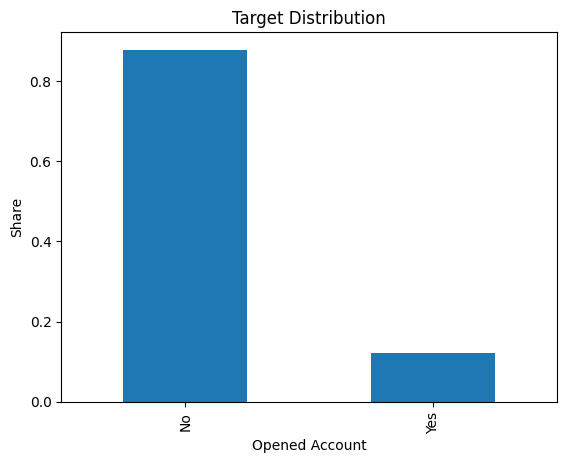

In [12]:
# Plot Target Distribution
ax = (training_df['y'].value_counts(normalize=True)
        .rename({0:'No',1:'Yes'})
        .plot(kind='bar'))
plt.title('Target Distribution'); 
plt.xlabel('Opened Account'); 
plt.ylabel('Share'); 
plt.show()

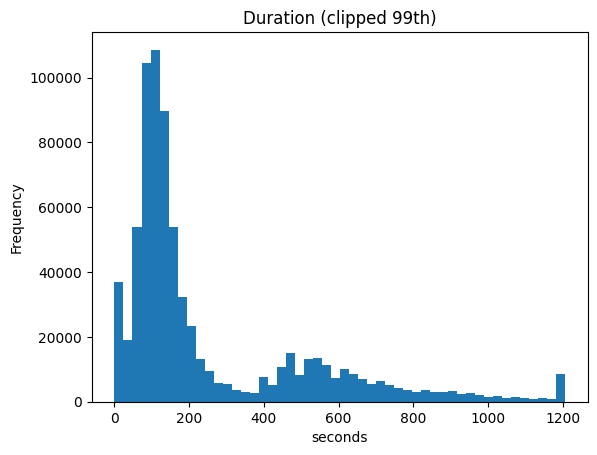

In [13]:
# Plot duration
training_df['duration'].clip(upper=training_df['duration'].quantile(0.99)).plot(kind='hist', bins=50)
plt.title('Duration (clipped 99th)'); 
plt.xlabel('seconds'); 
plt.show()

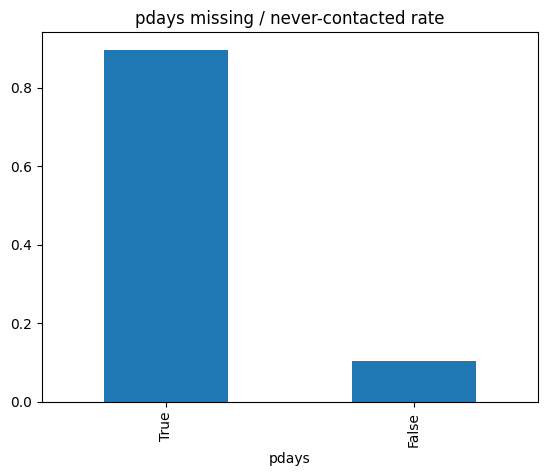

In [14]:
# Plot pdays missingness
(training_df['pdays'].eq(-1) | training_df['pdays'].isna()).value_counts(normalize=True).plot(kind='bar')
plt.title('pdays missing / never-contacted rate'); 
plt.show()

In [15]:
eda_summary(test_df)

======== First 5 Rows ========


,0,1,2,3,4
age,32,44,36,58,28
job,blue-collar,management,self-employed,blue-collar,technician
marital,married,married,married,married,single
education,secondary,tertiary,primary,secondary,secondary
default,no,no,no,no,no
balance,1397,23,46,-1380,1950
housing,yes,yes,yes,yes,yes
loan,no,no,yes,yes,no
contact,unknown,cellular,cellular,unknown,cellular
day,21,3,13,29,22



======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   age        250000 non-null  int64 
 1   job        250000 non-null  object
 2   marital    250000 non-null  object
 3   education  250000 non-null  object
 4   default    250000 non-null  object
 5   balance    250000 non-null  int64 
 6   housing    250000 non-null  object
 7   loan       250000 non-null  object
 8   contact    250000 non-null  object
 9   day        250000 non-null  int64 
 10  month      250000 non-null  object
 11  duration   250000 non-null  int64 
 12  campaign   250000 non-null  int64 
 13  pdays      250000 non-null  int64 
 14  previous   250000 non-null  int64 
 15  poutcome   250000 non-null  object
dtypes: int64(7), object(9)
memory usage: 30.5+ MB

======== Descriptive Statistics (Numeric Columns) ========


,age,balance,day,duration,campaign,pdays,previous
count,"250,000.000","250,000.000","250,000.000","250,000.000","250,000.000","250,000.000","250,000.000"
mean,40.932,"1,197.426",16.116,255.342,2.574,22.280,0.304
std,10.082,"2,741.521",8.259,271.404,2.710,76.916,1.385
min,18.000,"-8,019.000",1.000,3.000,1.000,-1.000,0.000
25%,33.000,0.000,9.000,91.000,1.000,-1.000,0.000
50%,39.000,631.000,17.000,133.000,2.000,-1.000,0.000
75%,48.000,"1,389.000",21.000,353.000,3.000,-1.000,0.000
max,95.000,"98,517.000",31.000,"4,918.000",58.000,871.000,150.000



======== Descriptive Statistics (Categorical Columns) ========


,job,marital,education,default,housing,loan,contact,month,poutcome
count,250000,250000,250000,250000,250000,250000,250000,250000,250000
unique,12,3,4,2,2,2,3,12,4
top,management,married,secondary,no,yes,no,cellular,may,unknown
freq,58636,160412,133724,245843,136534,214957,162462,76009,224115



======== Missing Values Summary ========


,Missing Count,Percentage
age,0,0.000
job,0,0.000
marital,0,0.000
education,0,0.000
default,0,0.000
balance,0,0.000
housing,0,0.000
loan,0,0.000
contact,0,0.000
day,0,0.000



======== Duplicated Rows ========
Total duplicated rows: 0

======== Data Types Count ========


object    9
int64     7
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


,age,balance,day,duration,campaign,pdays,previous
age,1.000,0.065,-0.014,-0.006,0.005,-0.022,0.005
balance,0.065,1.000,-0.008,0.114,-0.026,0.011,0.035
day,-0.014,-0.008,1.000,-0.056,0.183,-0.084,-0.047
duration,-0.006,0.114,-0.056,1.000,-0.085,0.046,0.038
campaign,0.005,-0.026,0.183,-0.085,1.000,-0.062,-0.025
pdays,-0.022,0.011,-0.084,0.046,-0.062,1.000,0.553
previous,0.005,0.035,-0.047,0.038,-0.025,0.553,1.000



======== Value Counts for Categorical Columns (Low Cardinality) ========

Value Counts for 'job':


job
management       58636
blue-collar      56970
technician       45936
admin.           27009
services         21312
retired          11611
self-employed     6424
unemployed        6013
entrepreneur      5955
housemaid         5245
student           3867
unknown           1022
Name: count, dtype: int64


Value Counts for 'marital':


marital
married     160412
single       64717
divorced     24871
Name: count, dtype: int64


Value Counts for 'education':


education
secondary    133724
tertiary      76037
primary       32989
unknown        7250
Name: count, dtype: int64


Value Counts for 'default':


default
no     245843
yes      4157
Name: count, dtype: int64


Value Counts for 'housing':


housing
yes    136534
no     113466
Name: count, dtype: int64


Value Counts for 'loan':


loan
no     214957
yes     35043
Name: count, dtype: int64


Value Counts for 'contact':


contact
cellular     162462
unknown       76896
telephone     10642
Name: count, dtype: int64


Value Counts for 'month':


month
may    76009
aug    42874
jul    36828
jun    31195
nov    22037
apr    13878
feb    12516
jan     6441
oct     3154
sep     2429
mar     1944
dec      695
Name: count, dtype: int64


Value Counts for 'poutcome':


poutcome
unknown    224115
failure     14844
success      6003
other        5038
Name: count, dtype: int64

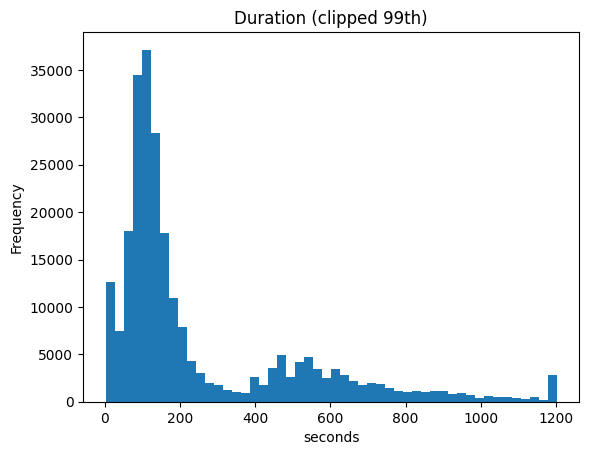

In [16]:
# Plot duration
test_df['duration'].clip(upper=test_df['duration'].quantile(0.99)).plot(kind='hist', bins=50)
plt.title('Duration (clipped 99th)'); 
plt.xlabel('seconds'); 
plt.show()

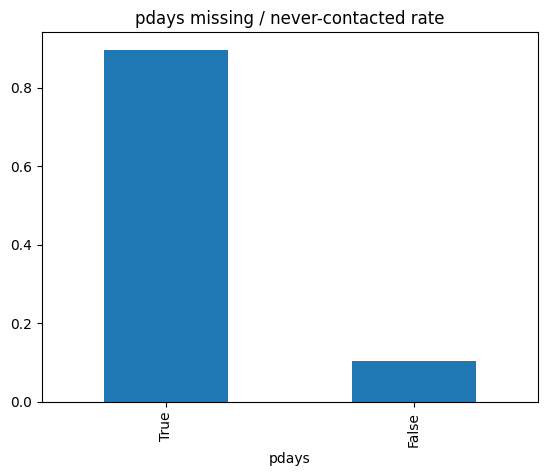

In [17]:
# Plot pdays missingness
(test_df['pdays'].eq(-1) | test_df['pdays'].isna()).value_counts(normalize=True).plot(kind='bar')
plt.title('pdays missing / never-contacted rate'); 
plt.show()

## Feature Engineering

#### Change the 'job' feature for a categorical datatype

In [18]:
def transform_job(df: pd.DataFrame) -> pd.DataFrame:
    # If the 'job' feature is already categorical, then remark about it and return
    if is_categorical_dtype(df['job']):
        print("The 'job' feature has already been transformed.  Operation cancelled.")
        return df

    out = df.copy()
    out['job'] = out['job'].astype('category')
        
    return out

#### Encode the 'marital' feature using OneHotEncoder.

In [19]:
def fit_marital(df: pd.DataFrame):
    global marital_encoder
    
    # If the 'marital' feature isn't present, then remark about it and return
    if 'marital' not in df.columns:
        print("The 'marital' feature has already been transformed.  Operation cancelled.")
        return
        
    marital_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    marital_encoder.fit(df[['marital']])

def transform_marital(df: pd.DataFrame, drop_original: bool) -> pd.DataFrame:
    """Idempotent one-hot transform for 'marital'.
    - Drops any previously generated marital one-hot columns.
    - Works even if called multiple times.
    - Robust to unseen categories if encoder was created with handle_unknown='ignore'.
    """
    # If the 'marital' feature isn't present, then remark about it and return
    if 'marital' not in df.columns:
        print("The 'marital' feature has already been transformed.  Operation cancelled.")
        return df
        
    # Ensure encoder is fitted
    if not hasattr(marital_encoder, "categories_"):
        marital_encoder.fit(df[["marital"]])

    # Compute consistent column names
    cols = marital_encoder.get_feature_names_out(["marital"])

    # Get a copy of the DataFrame to work upon.
    out = df.copy()
    
    # Transform to sparse matrix
    X = marital_encoder.transform(out[["marital"]])

    # Drop existing one-hot columns if present
    to_drop = [c for c in cols if c in out.columns]
    if to_drop:
        out = out.drop(columns=to_drop)

    # Build a (sparse) DataFrame aligned to df.index
    df_ohe = pd.DataFrame.sparse.from_spmatrix(X, index=out.index, columns=cols)
    df_ohe = df_ohe.astype("Int8")
    
    # Optionally drop the original column
    if drop_original and "marital" in out.columns:
        out = out.drop(columns=["marital"])

    # Concatenate and return
    return pd.concat([out, df_ohe], axis=1)

def save_marital_encoder():
    joblib.dump(marital_encoder, "marital_encoder.pkl")
    print('marital_encoder saved')

#### Encode the 'education' feature

In [20]:
education_encoder = LabelEncoder()

def fit_education(df: pd.DataFrame):
    # If the 'education' feature isn't present, then remark about it and return
    if 'education' not in df.columns:
        print("The 'education' feature has already been transformed.  Operation cancelled.")
        return

    education_encoder.fit(df['education'])

def transform_education(df: pd.DataFrame, drop_original: bool) -> pd.DataFrame:
    # If the 'education' feature isn't present, then remark about it and return
    if 'education' not in df.columns:
        print("The 'education' feature has already been transformed.  Operation cancelled.")
        return df

    out = df.copy()
    out['encoded_education'] = education_encoder.transform(out['education'])
    out['education_unknown'] = (out['education'] == 'unknown').astype('int8')

    if drop_original:
        out.drop('education', axis=1, inplace=True)
        
    return out

def save_education_encoder():
    joblib.dump(education_encoder, "education_encoder.pkl")
    print('education_encoder saved')

#### Convert 'default' feature to 0/1 values

In [21]:
def convert_default(df: pd.DataFrame, drop_original: bool) -> pd.DataFrame:
    # If the 'default' feature isn't present, then remark about it and return
    if 'default' not in df.columns:
        print("The 'default' feature has already been transformed.  Operation cancelled.")
        return df

    out = df.copy()
    
    out['default_bool'] = out['default'].str.lower().map({"yes": 1, "no": 0}).astype("Int8")

    if drop_original:
        out.drop('default', axis=1, inplace=True)

    return out

#### Convert 'housing' feature to a boolean

In [22]:
def convert_housing(df: pd.DataFrame, drop_original: bool) -> pd.DataFrame:
    # If the 'housing' feature isn't present, then remark about it and return
    if 'housing' not in df.columns:
        print("The 'housing' feature has already been transformed.  Operation cancelled.")
        return df

    out = df.copy()
    
    out['housing_bool'] = out['housing'].str.lower().map({"yes": 1, "no": 0}).astype("Int8")

    if drop_original:
        out.drop('housing', axis=1, inplace=True)

    return out

#### Convert 'loan' feature to a boolean

In [23]:
def convert_loan(df: pd.DataFrame, drop_original: bool) -> pd.DataFrame:
    # If the 'loan' feature isn't present, then remark about it and return
    if 'loan' not in df.columns:
        print("The 'loan' feature has already been transformed.  Operation cancelled.")
        return df

    out = df.copy()
    
    out['loan_bool'] = out['loan'].str.lower().map({"yes": 1, "no": 0}).astype("Int8")

    if drop_original:
        out.drop('loan', axis=1, inplace=True)

    return out

#### Change the 'contact' feature for a categorical datatype

In [24]:
def transform_contact(df: pd.DataFrame) -> pd.DataFrame:
    # If the 'contact' feature is already categorical, then remark about it and return
    if is_categorical_dtype(df['contact']):
        print("The 'contact' feature has already been transformed.  Operation cancelled.")
        return df

    out = df.copy()
    
    out['contact'] = out['contact'].astype('category')

    return out

#### Now, convert the date features 'day' and 'month' into new sine/cosine encodings, which are continuous.

In [25]:
# First, let's see if there are any leap-year dates in the dataset
training_df[(training_df['month'] == 'feb') & (training_df['day'] == 29)]

,age,job,marital,education,default,balance,housing,...,month,duration,campaign,pdays,previous,poutcome,y
91872,83,retired,divorced,unknown,no,676,no,...,feb,515,2,185,7,success,1
240103,29,unemployed,single,secondary,no,0,no,...,feb,255,1,183,2,success,1
303745,32,blue-collar,married,tertiary,no,1017,yes,...,feb,36,1,-1,0,unknown,0
346404,53,management,single,tertiary,no,2146,no,...,feb,147,3,189,3,failure,0
545811,34,management,married,tertiary,no,902,no,...,feb,139,2,184,4,success,1
666497,50,management,divorced,tertiary,no,1778,yes,...,feb,639,1,258,3,other,1
723662,45,unemployed,married,primary,no,474,no,...,feb,813,1,-1,0,unknown,1


In [26]:
# Alright, we found both Feb 29 as well as out of range day values.
# So, we'll choose 2020 as the year, since that's a leap year.
# Wealso take action to coerce the bad dates into good ones.
def convert_calendar_features(df, drop_originals: bool):
    # If the 'month' feature isn't present, then remark about it and return
    if 'month' not in df.columns:
        print("The 'month' feature has already been transformed.  Operation cancelled.")
        return df

    # Work on a copy so we don't mess stuff up if this fails halfway throug
    out = df.copy()

    # Create a numbered month series
    month_map = {
        "jan": 1,
        "feb": 2,
        "mar": 3,
        "apr": 4,
        "may": 5,
        "jun": 6,
        "jul": 7,
        "aug": 8,
        "sep": 9,
        "oct": 10,
        "nov": 11,
        "dec": 12
    }
    month = out["month"].str.lower().map(month_map)

    # Create a year series that is the correct length
    year_array = np.empty(out["month"].size)
    year_array.fill(2020)
    year = pd.Series(data=year_array, name='year')

    # Assemble those series into a DataFrame suitable for
    raw_date_df = pd.DataFrame(
        {'year': year,
         'month': month,
         'day': out['day']
        }
    )

    # Look for bad dates and try to show them
    bad = pd.to_datetime(raw_date_df, errors="coerce")
    raw_date_df.loc[bad.isna()]

    # There's some bogus dats in the dataset, so we need to do some hygiene.
    # 1) month-end day for each row (handles leap years)
    month_start = pd.to_datetime(dict(year=raw_date_df["year"],
                                      month=raw_date_df["month"],
                                      day=1))
    month_end_day = (month_start + pd.offsets.MonthEnd(0)).dt.day
    
    # 2) clip day into [1, month_end_day]
    day_clipped = raw_date_df["day"].clip(lower=1, upper=month_end_day)

    # 3) build safe dates
    date_df = pd.to_datetime(dict(year=raw_date_df["year"],
                                  month=raw_date_df["month"],
                                  day=day_clipped))
    
    # Flag rows that were adjusted
    adjusted = day_clipped.ne(raw_date_df["day"])
    print(f"Adjusted {adjusted.sum()} rows where day exceeded month length.")
    
    # Now, create new features for the day of year and cyclical encoding.
    out["day_of_year"] = date_df.dt.dayofyear
    out["day_sin"] = np.sin(2 * np.pi * out["day_of_year"] / 366.0)
    out["day_cos"] = np.cos(2 * np.pi * out["day_of_year"] / 366.0)

    if drop_originals:
        out.drop('month', axis=1, inplace=True)
        out.drop('day', axis=1, inplace=True)

    return out

#### Create 'previous_log' and 'previous_any' features from the 'previous' column

In [27]:
def transform_previous(df: pd.DataFrame, drop_original: bool) -> pd.DataFrame:
    # If the 'previous' feature isn't present, then remark about it and return
    if 'previous' not in df.columns:
        print("The 'previous' feature has already been transformed.  Operation cancelled.")
        return df

    out = df.copy()
    
    out['prev_any'] = (out['previous'] > 0).astype('int8')

    out['prev_log'] = np.where(out['previous'] > 0,
                                   np.log1p(out["previous"]),
                                   0)

    if drop_original:
        out.drop('previous', axis=1, inplace=True)

    return out    

#### Change the 'poutcome' feature for a categorical datatype

In [28]:
def transform_poutcome(df: pd.DataFrame) -> pd.DataFrame:
    # If the 'poutcome' feature is already categorical, then remark about it and return
    if is_categorical_dtype(df['poutcome']):
        print("The 'poutcome' feature has already been transformed.  Operation cancelled.")
        return df

    out = df.copy()
    
    out['poutcome'] = out['poutcome'].astype('category')

    return out

#### Define high-level 'fit' and 'transform' functions

In [29]:
# Fit the features
def fit_features(df: pd.DataFrame):
    fit_marital(df)
    fit_education(df)

    save_marital_encoder()
    save_education_encoder()

In [30]:
# Transform features
def transform_features(df: pd.DataFrame, drop_original: bool) -> pd.DataFrame:
    out_df = df.copy()

    out_df = transform_job(out_df)
    out_df = transform_marital(out_df, drop_original)
    out_df = transform_education(out_df, drop_original)
    out_df = convert_default(out_df, drop_original)
    out_df = convert_housing(out_df, drop_original)
    out_df = convert_loan(out_df, drop_original)
    out_df = transform_contact(out_df)
    out_df = convert_calendar_features(out_df, drop_original)
    
    # Add logarithmic duration
    out_df['log_duration'] = np.log1p(out_df['duration'])

    # The 'pdays' feature uses -1 to indicate nothing.  Replace all these with NaNs and add a 'pdays_missing' feature
    out_df.loc[out_df['pdays'] == -1, 'pdays'] = np.nan
    out_df["pdays_missing"] = (out_df["pdays"].isna()).astype("int8")

    out_df = transform_previous(out_df, drop_original)
    out_df = transform_poutcome(out_df)

    return out_df

### Fit to the training data, then transform both the training and test data

In [31]:
fit_features(training_df)

marital_encoder saved
education_encoder saved


In [32]:
training_df = transform_features(training_df, True)
training_df.head(10)

Adjusted 35 rows where day exceeded month length.


,age,job,balance,contact,duration,campaign,pdays,...,day_of_year,day_sin,day_cos,log_duration,pdays_missing,prev_any,prev_log
0,42,technician,7,cellular,117,3,NaN,...,238,-0.810,-0.586,4.771,1,0,0.000
1,38,blue-collar,514,unknown,185,1,NaN,...,170,0.221,-0.975,5.226,1,0,0.000
2,36,blue-collar,602,unknown,111,2,NaN,...,135,0.734,-0.679,4.718,1,0,0.000
3,27,student,34,unknown,10,2,NaN,...,149,0.551,-0.834,2.398,1,0,0.000
4,26,technician,889,cellular,902,1,NaN,...,34,0.551,0.834,6.806,1,0,0.000
5,24,admin.,1882,cellular,1010,3,NaN,...,111,0.944,-0.329,6.919,1,0,0.000
6,39,blue-collar,0,telephone,90,1,NaN,...,326,-0.634,0.773,4.511,1,0,0.000
7,50,admin.,1595,telephone,49,25,NaN,...,213,-0.493,-0.870,3.912,1,0,0.000
8,46,blue-collar,1463,cellular,50,1,NaN,...,217,-0.551,-0.834,3.932,1,0,0.000
9,39,management,25,cellular,119,1,NaN,...,129,0.800,-0.600,4.787,1,0,0.000


In [33]:
test_df = transform_features(test_df, True)
test_df.head(10)

Adjusted 8 rows where day exceeded month length.


,age,job,balance,contact,duration,campaign,pdays,...,day_of_year,day_sin,day_cos,log_duration,pdays_missing,prev_any,prev_log
0,32,blue-collar,1397,unknown,224,1,NaN,...,142,0.647,-0.762,5.416,1,0,0.000
1,44,management,23,cellular,586,2,NaN,...,94,0.999,-0.043,6.375,1,0,0.000
2,36,self-employed,46,cellular,111,2,NaN,...,134,0.745,-0.667,4.718,1,0,0.000
3,58,blue-collar,-1380,unknown,125,1,NaN,...,150,0.537,-0.844,4.836,1,0,0.000
4,28,technician,1950,cellular,181,1,NaN,...,204,-0.353,-0.936,5.204,1,0,0.000
5,43,management,3025,cellular,89,2,NaN,...,203,-0.337,-0.942,4.500,1,0,0.000
6,26,services,3511,cellular,816,3,NaN,...,29,0.478,0.879,6.706,1,0,0.000
7,60,management,79,cellular,707,1,NaN,...,191,-0.137,-0.991,6.562,1,0,0.000
8,45,blue-collar,16,telephone,173,1,NaN,...,37,0.593,0.805,5.159,1,0,0.000
9,41,management,46,cellular,657,4,NaN,...,231,-0.734,-0.679,6.489,1,0,0.000


In [34]:
# Examine the transformed training dataset
eda_summary(training_df)

======== First 5 Rows ========


,0,1,2,3,4
age,42,38,36,27,26
job,technician,blue-collar,blue-collar,student,technician
balance,7,514,602,34,889
contact,cellular,unknown,unknown,unknown,cellular
duration,117,185,111,10,902
campaign,3,1,2,2,1
pdays,NaN,NaN,NaN,NaN,NaN
poutcome,unknown,unknown,unknown,unknown,unknown
y,0,0,0,0,1
marital_divorced,0,0,0,0,0



======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   age                750000 non-null  int64   
 1   job                750000 non-null  category
 2   balance            750000 non-null  int64   
 3   contact            750000 non-null  category
 4   duration           750000 non-null  int64   
 5   campaign           750000 non-null  int64   
 6   pdays              77566 non-null   float64 
 7   poutcome           750000 non-null  category
 8   y                  750000 non-null  int64   
 9   marital_divorced   750000 non-null  Int8    
 10  marital_married    750000 non-null  Int8    
 11  marital_single     750000 non-null  Int8    
 12  encoded_education  750000 non-null  int64   
 13  education_unknown  750000 non-null  int8    
 14  default_bool       750000 non-null  Int8    
 15  

,age,balance,duration,campaign,pdays,y,marital_divorced,...,day_of_year,day_sin,day_cos,log_duration,pdays_missing,prev_any,prev_log
count,"750,000.000","750,000.000","750,000.000","750,000.000","77,566.000","750,000.000","750,000.000",...,"750,000.000","750,000.000","750,000.000","750,000.000","750,000.000","750,000.000","750,000.000"
mean,40.926,"1,204.067",256.229,2.577,225.382,0.121,0.099,...,175.992,0.109,-0.470,5.065,0.897,0.103,0.123
std,10.099,"2,836.097",272.556,2.719,108.892,0.326,0.299,...,72.128,0.632,0.606,1.032,0.305,0.305,0.399
min,18.000,"-8,019.000",1.000,1.000,0.000,0.000,0.000,...,1.000,-1.000,-1.000,0.693,0.000,0.000,0.000
25%,33.000,0.000,91.000,1.000,144.000,0.000,0.000,...,134.000,-0.607,-0.879,4.522,1.000,0.000,0.000
50%,39.000,634.000,133.000,2.000,187.000,0.000,0.000,...,161.000,0.369,-0.692,4.898,1.000,0.000,0.000
75%,48.000,"1,390.000",361.000,3.000,338.000,0.000,0.000,...,221.000,0.686,-0.485,5.892,1.000,0.000,0.000
max,95.000,"99,717.000","4,918.000",63.000,871.000,1.000,1.000,...,366.000,1.000,1.000,8.501,1.000,1.000,5.303



======== Descriptive Statistics (Categorical Columns) ========


,job,contact,poutcome
count,750000,750000,750000
unique,12,3,4
top,management,cellular,unknown
freq,175541,486655,672450



======== Missing Values Summary ========


,Missing Count,Percentage
age,0,0.000
job,0,0.000
balance,0,0.000
contact,0,0.000
duration,0,0.000
campaign,0,0.000
pdays,672434,89.658
poutcome,0,0.000
y,0,0.000
marital_divorced,0,0.000



======== Duplicated Rows ========
Total duplicated rows: 0

======== Data Types Count ========


int64       6
Int8        6
float64     5
int8        3
category    1
category    1
category    1
int32       1
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


,age,balance,duration,campaign,pdays,y,marital_divorced,...,day_of_year,day_sin,day_cos,log_duration,pdays_missing,prev_any,prev_log
age,1.000,0.063,-0.004,0.002,-0.129,0.010,0.145,...,0.095,-0.124,0.006,-0.002,0.001,-0.001,0.005
balance,0.063,1.000,0.110,-0.028,-0.172,0.123,-0.024,...,0.073,-0.045,0.104,0.094,-0.043,0.043,0.044
duration,-0.004,0.110,1.000,-0.083,-0.047,0.519,0.008,...,-0.039,0.054,0.038,0.845,-0.061,0.061,0.057
campaign,0.002,-0.028,-0.083,1.000,0.075,-0.076,-0.009,...,0.083,-0.157,-0.133,-0.217,0.076,-0.076,-0.055
pdays,-0.129,-0.172,-0.047,0.075,1.000,-0.307,0.015,...,-0.275,0.426,-0.309,-0.108,NaN,-0.004,-0.109
y,0.010,0.123,0.519,-0.076,-0.307,1.000,-0.009,...,-0.006,-0.016,0.096,0.436,-0.169,0.170,0.163
marital_divorced,0.145,-0.024,0.008,-0.009,0.015,-0.009,1.000,...,-0.004,0.012,-0.002,0.002,-0.008,0.007,0.008
marital_married,0.318,0.003,-0.048,0.025,-0.003,-0.077,-0.443,...,0.076,-0.067,-0.046,-0.037,0.037,-0.037,-0.034
marital_single,-0.447,0.014,0.048,-0.021,-0.007,0.091,-0.197,...,-0.080,0.065,0.052,0.039,-0.036,0.036,0.032
encoded_education,-0.128,0.061,0.013,0.008,-0.181,0.080,-0.007,...,0.083,-0.128,0.087,0.006,-0.028,0.028,0.028



======== Value Counts for Categorical Columns (Low Cardinality) ========

Value Counts for 'job':


job
management       175541
blue-collar      170498
technician       138107
admin.            81492
services          64209
retired           35185
self-employed     19020
entrepreneur      17718
unemployed        17634
housemaid         15912
student           11767
unknown            2917
Name: count, dtype: int64


Value Counts for 'contact':


contact
cellular     486655
unknown      231627
telephone     31718
Name: count, dtype: int64


Value Counts for 'poutcome':


poutcome
unknown    672450
failure     45115
success     17691
other       14744
Name: count, dtype: int64

In [35]:
# Examine the transformed test dataset
eda_summary(test_df)

======== First 5 Rows ========


,0,1,2,3,4
age,32,44,36,58,28
job,blue-collar,management,self-employed,blue-collar,technician
balance,1397,23,46,-1380,1950
contact,unknown,cellular,cellular,unknown,cellular
duration,224,586,111,125,181
campaign,1,2,2,1,1
pdays,NaN,NaN,NaN,NaN,NaN
poutcome,unknown,unknown,unknown,unknown,unknown
marital_divorced,0,0,0,0,0
marital_married,1,1,1,1,0



======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   age                250000 non-null  int64   
 1   job                250000 non-null  category
 2   balance            250000 non-null  int64   
 3   contact            250000 non-null  category
 4   duration           250000 non-null  int64   
 5   campaign           250000 non-null  int64   
 6   pdays              25888 non-null   float64 
 7   poutcome           250000 non-null  category
 8   marital_divorced   250000 non-null  Int8    
 9   marital_married    250000 non-null  Int8    
 10  marital_single     250000 non-null  Int8    
 11  encoded_education  250000 non-null  int64   
 12  education_unknown  250000 non-null  int8    
 13  default_bool       250000 non-null  Int8    
 14  housing_bool       250000 non-null  Int8    
 15  

,age,balance,duration,campaign,pdays,marital_divorced,marital_married,...,day_of_year,day_sin,day_cos,log_duration,pdays_missing,prev_any,prev_log
count,"250,000.000","250,000.000","250,000.000","250,000.000","25,888.000","250,000.000","250,000.000",...,"250,000.000","250,000.000","250,000.000","250,000.000","250,000.000","250,000.000","250,000.000"
mean,40.932,"1,197.426",255.342,2.574,223.815,0.099,0.642,...,175.924,0.109,-0.469,5.061,0.896,0.104,0.124
std,10.082,"2,741.521",271.404,2.710,108.736,0.299,0.480,...,72.239,0.632,0.607,1.033,0.305,0.305,0.402
min,18.000,"-8,019.000",3.000,1.000,1.000,0.000,0.000,...,1.000,-1.000,-1.000,1.386,0.000,0.000,0.000
25%,33.000,0.000,91.000,1.000,137.000,0.000,0.000,...,134.000,-0.607,-0.879,4.522,1.000,0.000,0.000
50%,39.000,631.000,133.000,2.000,187.000,0.000,1.000,...,161.000,0.369,-0.692,4.898,1.000,0.000,0.000
75%,48.000,"1,389.000",353.000,3.000,336.000,0.000,1.000,...,221.000,0.710,-0.485,5.869,1.000,0.000,0.000
max,95.000,"98,517.000","4,918.000",58.000,871.000,1.000,1.000,...,366.000,1.000,1.000,8.501,1.000,1.000,5.017



======== Descriptive Statistics (Categorical Columns) ========


,job,contact,poutcome
count,250000,250000,250000
unique,12,3,4
top,management,cellular,unknown
freq,58636,162462,224115



======== Missing Values Summary ========


,Missing Count,Percentage
age,0,0.000
job,0,0.000
balance,0,0.000
contact,0,0.000
duration,0,0.000
campaign,0,0.000
pdays,224112,89.645
poutcome,0,0.000
marital_divorced,0,0.000
marital_married,0,0.000



======== Duplicated Rows ========
Total duplicated rows: 0

======== Data Types Count ========


Int8        6
int64       5
float64     5
int8        3
category    1
category    1
category    1
int32       1
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


,age,balance,duration,campaign,pdays,marital_divorced,marital_married,...,day_of_year,day_sin,day_cos,log_duration,pdays_missing,prev_any,prev_log
age,1.000,0.065,-0.006,0.005,-0.130,0.142,0.318,...,0.095,-0.123,0.006,-0.002,0.001,-0.001,0.004
balance,0.065,1.000,0.114,-0.026,-0.175,-0.026,0.001,...,0.075,-0.045,0.110,0.098,-0.045,0.045,0.045
duration,-0.006,0.114,1.000,-0.085,-0.058,0.007,-0.045,...,-0.038,0.051,0.040,0.845,-0.061,0.061,0.056
campaign,0.005,-0.026,-0.085,1.000,0.070,-0.005,0.023,...,0.086,-0.159,-0.132,-0.219,0.076,-0.076,-0.055
pdays,-0.130,-0.175,-0.058,0.070,1.000,0.010,-0.009,...,-0.271,0.423,-0.303,-0.119,NaN,-0.002,-0.097
marital_divorced,0.142,-0.026,0.007,-0.005,0.010,1.000,-0.445,...,-0.006,0.015,-0.002,0.002,-0.007,0.007,0.006
marital_married,0.318,0.001,-0.045,0.023,-0.009,-0.445,1.000,...,0.078,-0.067,-0.046,-0.034,0.039,-0.039,-0.035
marital_single,-0.445,0.016,0.045,-0.021,0.003,-0.196,-0.791,...,-0.081,0.063,0.052,0.036,-0.038,0.038,0.034
encoded_education,-0.130,0.063,0.017,0.008,-0.185,-0.008,-0.138,...,0.082,-0.128,0.088,0.010,-0.030,0.030,0.030
education_unknown,0.059,0.016,0.009,0.005,-0.019,-0.010,0.004,...,-0.020,0.022,-0.007,0.003,-0.009,0.009,0.009



======== Value Counts for Categorical Columns (Low Cardinality) ========

Value Counts for 'job':


job
management       58636
blue-collar      56970
technician       45936
admin.           27009
services         21312
retired          11611
self-employed     6424
unemployed        6013
entrepreneur      5955
housemaid         5245
student           3867
unknown           1022
Name: count, dtype: int64


Value Counts for 'contact':


contact
cellular     162462
unknown       76896
telephone     10642
Name: count, dtype: int64


Value Counts for 'poutcome':


poutcome
unknown    224115
failure     14844
success      6003
other        5038
Name: count, dtype: int64

## Validation Strategy

When working with imbalanced classification tasks, having a reliable validation approach is essential to avoid overly optimistic results.  
In this dataset, the positive class (customers who open a new account) makes up only ~12% of the samples.  
To ensure that the class distribution is preserved in each split, we use **Stratified K-Fold Cross-Validation**.

Key points of the validation setup:

- **Stratification:** preserves the ratio of positive/negative labels in each fold, giving more stable AUC estimates.  
- **Number of folds:** we use 5 folds, which balances stability with training time. Each fold trains on 80% of the data and validates on 20%.  
- **Evaluation metric:** the competition is scored on **AUC (Area Under the ROC Curve)**, which is well-suited for imbalanced problems because it is threshold-independent.  
- **Early stopping:** models are trained with early stopping rounds to prevent overfitting and automatically determine the optimal number of boosting iterations.  

This strategy provides a robust estimate of how the model is likely to perform on unseen data, and ensures that the final model selection is not biased by a single train/validation split.


## Build and Train the Model

In [36]:
# Separate the predictors(X) from the target(y)
TARGET = "y"

X = training_df.drop(columns=[TARGET])
y = training_df[TARGET]

#### Train with ad hoc hyperparameters

In [37]:
def stratified_subsample(X, y, n=200_000, seed=42):
    import numpy as np
    pos_idx = y[y==1].index.to_numpy()
    neg_idx = y[y==0].index.to_numpy()
    rng = np.random.default_rng(seed)
    k_pos = int(n * y.mean())
    k_neg = n - k_pos
    keep = np.r_[rng.choice(pos_idx, k_pos, replace=False),
                 rng.choice(neg_idx, k_neg, replace=False)]
    keep.sort()
    return X.loc[keep], y.loc[keep]

X_tune, y_tune = stratified_subsample(X, y, n=200_000, seed=seed)
folds_tune = list(StratifiedKFold(5, shuffle=True, random_state=seed).split(X_tune, y_tune))

In [38]:
# imbalance weight
pos = y.sum()
neg = len(y) - pos
spw = neg / pos

params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "enable_categorical": True,
    "tree_method": "hist" if not USE_GPU else "gpu_hist",
    "predictor": "auto" if not USE_GPU else "gpu_predictor",
    "learning_rate": 0.03,
    "max_depth": 7,               # ≈ num_leaves ~ 128
    "min_child_weight": 50,       # ≈ LGBM min_data_in_leaf
    "subsample": 0.8,             # ≈ bagging_fraction
    "colsample_bytree": 0.8,      # ≈ feature_fraction
    "alpha": 0.0,                 # L1
    "lambda": 5.0,                # L2
    "gamma": 0.0,
    "scale_pos_weight": spw,
    "max_bin": 512,
    "colsample_bylevel": 0.9,
    "seed": seed,
}

dall = xgb.DMatrix(X, label=y, enable_categorical=True)

# Use the SAME folds in xgb.cv to pick rounds
print("Starting cross-fold validation")
cv_res = xgb.cv(
    params,
    dall,
    num_boost_round=10000,
    folds=folds_tune,
    early_stopping_rounds=300,
    seed=seed,
    verbose_eval=200,
)
best_n_rounds = len(cv_res)
print("Done.")
print("CV AUC:", cv_res["test-auc-mean"].iloc[-1], "@ rounds:", best_n_rounds)

# Final model on ALL data for exactly that many rounds
print("Training model...")
model = xgb.train(params, dall, num_boost_round=best_n_rounds)
print("Done.")

y_all_pred = model.predict(dall)
print("Validation AUC:", roc_auc_score(y, y_all_pred))

Starting cross-fold validation
[0]	train-auc:0.94472+0.00145	test-auc:0.94299+0.00176
[200]	train-auc:0.96610+0.00032	test-auc:0.96236+0.00122
[400]	train-auc:0.97008+0.00031	test-auc:0.96459+0.00117
[600]	train-auc:0.97245+0.00029	test-auc:0.96543+0.00112
[800]	train-auc:0.97423+0.00028	test-auc:0.96583+0.00105
[1000]	train-auc:0.97571+0.00027	test-auc:0.96609+0.00104
[1200]	train-auc:0.97700+0.00024	test-auc:0.96620+0.00101
[1400]	train-auc:0.97812+0.00023	test-auc:0.96628+0.00100
[1600]	train-auc:0.97916+0.00021	test-auc:0.96631+0.00099
[1800]	train-auc:0.98011+0.00022	test-auc:0.96630+0.00098
[1946]	train-auc:0.98076+0.00022	test-auc:0.96628+0.00098
Done.
CV AUC: 0.9663239622576215 @ rounds: 1648
Training model...
Done.
Validation AUC: 0.9744172217041351


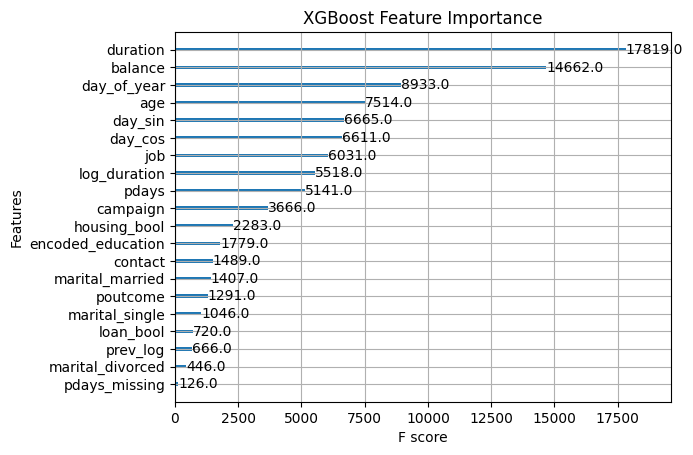

In [39]:
# Plot feature importances
xgb.plot_importance(model, max_num_features=20)
plt.title('XGBoost Feature Importance'); plt.show()

## Hyperparameter Tuning with Optuna

In [40]:
# Reuse the K-folds from the initial training
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
# folds = list(kf.split(X, y))

sampler = optuna.samplers.TPESampler(
    multivariate=True, group=True, n_startup_trials=10, seed=seed
)

pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)

In [41]:
def build_fold_dmats(X, y, folds, enable_cat=True):
    out = []
    for tr, va in folds:
        dtr = xgb.DMatrix(X.iloc[tr], label=y.iloc[tr], enable_categorical=enable_cat)
        dva = xgb.DMatrix(X.iloc[va], label=y.iloc[va], enable_categorical=enable_cat)
        out.append((dtr, dva, va))
    return out

fold_dmats = build_fold_dmats(X_tune, y_tune, folds_tune, enable_cat=True)

In [42]:
def objective(trial):
    grow_mode = trial.suggest_categorical("grow_mode", ["depth", "lossguide"])

    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "gpu_hist" if USE_GPU else "hist",
        "predictor": "gpu_predictor" if USE_GPU else "auto",
        "enable_categorical": True,
        "scale_pos_weight": spw,
        "seed": seed,
        "verbosity": 0,

        # tuned knobs
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.05, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.6, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "alpha": trial.suggest_float("alpha", 1e-6, 1.0, log=True),
        "lambda": trial.suggest_float("lambda", 1e-4, 10.0, log=True),
        "max_bin": trial.suggest_categorical("max_bin", [128, 256]),
    }

    if grow_mode == "depth":
        params["max_depth"] = trial.suggest_int("max_depth", 6, 9)
        params["min_child_weight"] = trial.suggest_float("min_child_weight", 20.0, 200.0, log=True)
    else:
        params["grow_policy"] = "lossguide"
        params["max_depth"] = 0
        params["max_leaves"] = trial.suggest_int("max_leaves", 128, 512, log=True)
        params["min_child_weight"] = trial.suggest_float("min_child_weight", 10.0, 120.0, log=True)

    # Use the subsample label length
    oof = np.full(len(y_tune), np.nan, dtype=float)
    
    for dtr, dva, va_idx in fold_dmats:
        booster = xgb.train(
            params, dtr, num_boost_round=3000,
            evals=[(dva, "valid")],
            early_stopping_rounds=150,
            verbose_eval=False,
            callbacks=[optuna.integration.XGBoostPruningCallback(trial, "valid-auc")],
        )
        oof[va_idx] = booster.predict(dva, iteration_range=(0, booster.best_iteration + 1))
    return roc_auc_score(y_tune, oof)

In [43]:
study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)

seed_params = params.copy()

# Make it consistent with the search space:
seed_params.update({
    "grow_mode": "depth",
    "learning_rate": min(max(seed_params.get("learning_rate", 0.05), 0.02), 0.05),
    "subsample": min(max(seed_params.get("subsample", 0.8), 0.6), 1.0),
    "colsample_bytree": min(max(seed_params.get("colsample_bytree", 0.8), 0.6), 1.0),
    "colsample_bylevel": 0.9,
    "colsample_bynode": 0.8,
    "gamma": max(seed_params.get("gamma", 0.0), 0.0),
    "alpha": max(seed_params.get("alpha", 1e-6), 1e-6),
    "lambda": max(seed_params.get("lambda", 5.0), 1e-4),
    "max_bin": 256,
    "max_depth": 7,
})

# Supply the study with the ad hoc parameters
study.enqueue_trial(seed_params)

study.optimize(objective, n_trials=150, show_progress_bar=True)

print("Best AUC:", study.best_value)
print("Best params:", study.best_params)

[I 2025-08-30 18:06:17,748] A new study created in memory with name: no-name-614711f4-827f-43be-982b-967e347009a1


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-08-30 18:07:15,097] Trial 0 finished with value: 0.9653042394342862 and parameters: {'grow_mode': 'depth', 'learning_rate': 0.03, 'subsample': 0.8, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'colsample_bynode': 0.8, 'gamma': 0.0, 'alpha': 1e-06, 'lambda': 5.0, 'max_bin': 256, 'max_depth': 7, 'min_child_weight': 50}. Best is trial 0 with value: 0.9653042394342862.
[I 2025-08-30 18:08:01,741] Trial 1 finished with value: 0.9653114084591973 and parameters: {'grow_mode': 'depth', 'learning_rate': 0.03548192028285041, 'subsample': 0.7486819617610624, 'colsample_bytree': 0.7012601468657553, 'colsample_bylevel': 0.8293941403510712, 'colsample_bynode': 0.7042523123379395, 'gamma': 4.973739746328509, 'alpha': 0.0026069315285398003, 'lambda': 0.00028582190510940096, 'max_bin': 256, 'max_depth': 9, 'min_child_weight': 37.129494917525676}. Best is trial 1 with value: 0.9653114084591973.
[I 2025-08-30 18:09:03,132] Trial 2 finished with value: 0.9644338309498517 and parameters: {'gr

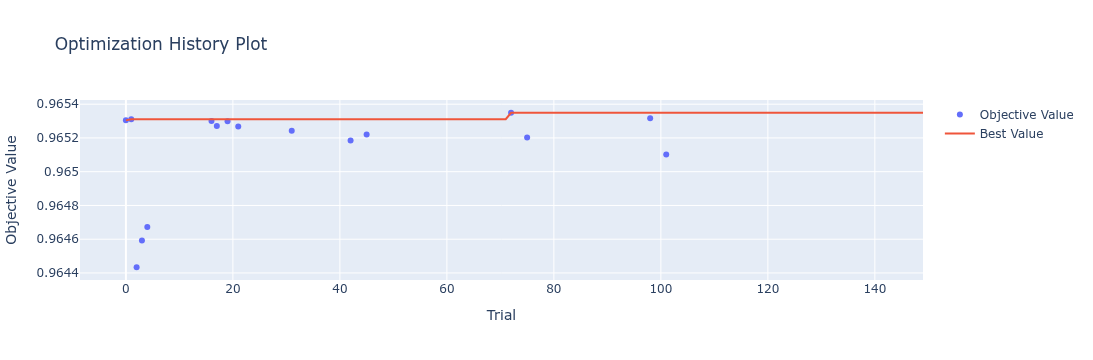

In [48]:
# Plot Optuna optimization history plots
ov.plot_optimization_history(study)

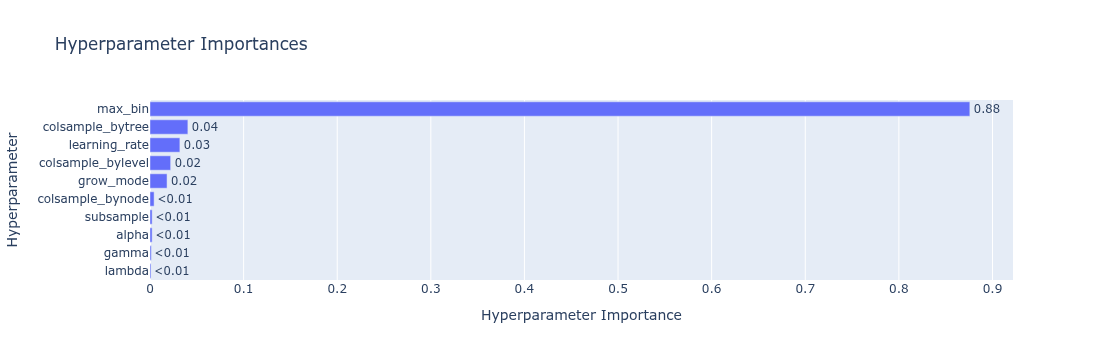

In [49]:
# Plot Optuna's idea of the importance of each of the parameters
ov.plot_param_importances(study)

## Final Model Training

In [50]:
def finalize_params(best_params, use_gpu=False, spw=1.0, seed=42):
    p = best_params.copy()

    # Map our custom branch key → real XGBoost params
    if "grow_mode" in p:
        gm = p.pop("grow_mode")
        if gm == "lossguide":
            p["grow_policy"] = "lossguide"
            p["max_depth"] = 0                 # required with lossguide
            # expect 'max_leaves' to be present from tuning
        else:
            p.pop("max_leaves", None)          # depth mode doesn't use this

    # Ensure required fixed bits
    p.update({
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist" if not USE_GPU else "gpu_hist",
        "predictor": "auto" if not USE_GPU else "gpu_predictor",
        "enable_categorical": True,
        "scale_pos_weight": float(spw),
        "seed": seed,
        "verbosity": 1,
    })

    # Remove any None/unexpected keys just in case
    for k in ["grow_mode"]:
        p.pop(k, None)
    return p

best_params_final = finalize_params(study.best_params, use_gpu=USE_GPU, spw=spw, seed=seed)


In [52]:
# Train final with best settings
print("Training model on optuna-derived settings....")

# Start from Optuna's best and add the fixed bits
best_params = finalize_params(study.best_params, use_gpu=USE_GPU, spw=spw, seed=seed)

# Use CV to get best number of rounds with early stopping
cv_res = xgb.cv(
    best_params,
    dall,
    num_boost_round=10000,
    folds=folds_tune,
    early_stopping_rounds=300,
    seed=seed,
    verbose_eval=200,
)
best_n_rounds = len(cv_res)
print("Best CV AUC:", cv_res["test-auc-mean"].iloc[-1], " @ rounds:", best_n_rounds)

# Train final on ALL data for best_n_rounds
final_model = xgb.train(
    best_params,
    dall,
    num_boost_round=best_n_rounds
)

print("Done")

Training model on optuna-derived settings....
[0]	train-auc:0.95430+0.00051	test-auc:0.94984+0.00198
[200]	train-auc:0.98068+0.00021	test-auc:0.96587+0.00117
[400]	train-auc:0.98580+0.00025	test-auc:0.96594+0.00112
[570]	train-auc:0.98705+0.00029	test-auc:0.96588+0.00113
Best CV AUC: 0.9659957982693277  @ rounds: 272
Done


In [55]:
# Let's see how the fully trained model does
y_final_valid_pred = final_model.predict(dall)
print("Validation AUC:", roc_auc_score(y, y_final_valid_pred))

Validation AUC: 0.974249668936059


## Test Using Original Dataset

The playground data was synthetically generated using the [Bank Marketing Dataset](https://www.kaggle.com/datasets/sushant097/bank-marketing-dataset-full) dataset.  Let's see how the model performs on this "original" dataset.

In [56]:
ORIGINAL_PATH = '/kaggle/input/bank-marketing-dataset-full/'
ORIGINAL_PATH = 'original_dataset/'

In [57]:
import pandas as pd

csv_path = ORIGINAL_PATH + "bank-full.csv"
original_df = pd.read_csv(csv_path, sep=";", quotechar='"')
original_df.head()

,age,job,marital,education,default,balance,housing,...,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,...,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,...,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,...,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,...,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,...,may,198,1,-1,0,unknown,no


In [58]:
eda_summary(original_df)

======== First 5 Rows ========


,0,1,2,3,4
age,58,44,33,47,33
job,management,technician,entrepreneur,blue-collar,unknown
marital,married,single,married,married,single
education,tertiary,secondary,secondary,unknown,unknown
default,no,no,no,no,no
balance,2143,29,2,1506,1
housing,yes,yes,yes,yes,no
loan,no,no,yes,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5



======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB

======== Descriptive Statistics (Numeric Columns) ========


,age,balance,day,duration,campaign,pdays,previous
count,"45,211.000","45,211.000","45,211.000","45,211.000","45,211.000","45,211.000","45,211.000"
mean,40.936,"1,362.272",15.806,258.163,2.764,40.198,0.580
std,10.619,"3,044.766",8.322,257.528,3.098,100.129,2.303
min,18.000,"-8,019.000",1.000,0.000,1.000,-1.000,0.000
25%,33.000,72.000,8.000,103.000,1.000,-1.000,0.000
50%,39.000,448.000,16.000,180.000,2.000,-1.000,0.000
75%,48.000,"1,428.000",21.000,319.000,3.000,-1.000,0.000
max,95.000,"102,127.000",31.000,"4,918.000",63.000,871.000,275.000



======== Descriptive Statistics (Categorical Columns) ========


,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922



======== Missing Values Summary ========


,Missing Count,Percentage
age,0,0.000
job,0,0.000
marital,0,0.000
education,0,0.000
default,0,0.000
balance,0,0.000
housing,0,0.000
loan,0,0.000
contact,0,0.000
day,0,0.000



======== Duplicated Rows ========
Total duplicated rows: 0

======== Data Types Count ========


object    10
int64      7
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


,age,balance,day,duration,campaign,pdays,previous
age,1.000,0.098,-0.009,-0.005,0.005,-0.024,0.001
balance,0.098,1.000,0.005,0.022,-0.015,0.003,0.017
day,-0.009,0.005,1.000,-0.030,0.162,-0.093,-0.052
duration,-0.005,0.022,-0.030,1.000,-0.085,-0.002,0.001
campaign,0.005,-0.015,0.162,-0.085,1.000,-0.089,-0.033
pdays,-0.024,0.003,-0.093,-0.002,-0.089,1.000,0.455
previous,0.001,0.017,-0.052,0.001,-0.033,0.455,1.000



======== Value Counts for Categorical Columns (Low Cardinality) ========

Value Counts for 'job':


job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64


Value Counts for 'marital':


marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64


Value Counts for 'education':


education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64


Value Counts for 'default':


default
no     44396
yes      815
Name: count, dtype: int64


Value Counts for 'housing':


housing
yes    25130
no     20081
Name: count, dtype: int64


Value Counts for 'loan':


loan
no     37967
yes     7244
Name: count, dtype: int64


Value Counts for 'contact':


contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64


Value Counts for 'month':


month
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: count, dtype: int64


Value Counts for 'poutcome':


poutcome
unknown    36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64


Value Counts for 'y':


y
no     39922
yes     5289
Name: count, dtype: int64

In [59]:
# Take the data through the transformations
original_df = transform_features(original_df, True)
original_df.head()

Adjusted 0 rows where day exceeded month length.


,age,job,balance,contact,duration,campaign,pdays,...,day_of_year,day_sin,day_cos,log_duration,pdays_missing,prev_any,prev_log
0,58,management,2143,unknown,261,1,NaN,...,126,0.830,-0.558,5.568,1,0,0.000
1,44,technician,29,unknown,151,1,NaN,...,126,0.830,-0.558,5.024,1,0,0.000
2,33,entrepreneur,2,unknown,76,1,NaN,...,126,0.830,-0.558,4.344,1,0,0.000
3,47,blue-collar,1506,unknown,92,1,NaN,...,126,0.830,-0.558,4.533,1,0,0.000
4,33,unknown,1,unknown,198,1,NaN,...,126,0.830,-0.558,5.293,1,0,0.000


In [60]:
eda_summary(original_df)

======== First 5 Rows ========


,0,1,2,3,4
age,58,44,33,47,33
job,management,technician,entrepreneur,blue-collar,unknown
balance,2143,29,2,1506,1
contact,unknown,unknown,unknown,unknown,unknown
duration,261,151,76,92,198
campaign,1,1,1,1,1
pdays,NaN,NaN,NaN,NaN,NaN
poutcome,unknown,unknown,unknown,unknown,unknown
y,no,no,no,no,no
marital_divorced,0,0,0,0,0



======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   age                45211 non-null  int64   
 1   job                45211 non-null  category
 2   balance            45211 non-null  int64   
 3   contact            45211 non-null  category
 4   duration           45211 non-null  int64   
 5   campaign           45211 non-null  int64   
 6   pdays              8257 non-null   float64 
 7   poutcome           45211 non-null  category
 8   y                  45211 non-null  object  
 9   marital_divorced   45211 non-null  Int8    
 10  marital_married    45211 non-null  Int8    
 11  marital_single     45211 non-null  Int8    
 12  encoded_education  45211 non-null  int64   
 13  education_unknown  45211 non-null  int8    
 14  default_bool       45211 non-null  Int8    
 15  housing_bool       

,age,balance,duration,campaign,pdays,marital_divorced,marital_married,...,day_of_year,day_sin,day_cos,log_duration,pdays_missing,prev_any,prev_log
count,"45,211.000","45,211.000","45,211.000","45,211.000","8,257.000","45,211.000","45,211.000",...,"45,211.000","45,211.000","45,211.000","45,211.000","45,211.000","45,211.000","45,211.000"
mean,40.936,"1,362.272",258.163,2.764,224.578,0.115,0.602,...,172.109,0.145,-0.431,5.172,0.817,0.183,0.226
std,10.619,"3,044.766",257.528,3.098,115.344,0.319,0.490,...,74.763,0.631,0.628,0.922,0.386,0.386,0.533
min,18.000,"-8,019.000",0.000,1.000,1.000,0.000,0.000,...,6.000,-1.000,-1.000,0.000,0.000,0.000,0.000
25%,33.000,72.000,103.000,1.000,133.000,0.000,0.000,...,130.000,-0.551,-0.879,4.644,1.000,0.000,0.000
50%,39.000,448.000,180.000,2.000,194.000,0.000,1.000,...,156.000,0.432,-0.679,5.198,1.000,0.000,0.000
75%,48.000,"1,428.000",319.000,3.000,327.000,0.000,1.000,...,218.000,0.722,-0.279,5.768,1.000,0.000,0.000
max,95.000,"102,127.000","4,918.000",63.000,871.000,1.000,1.000,...,366.000,1.000,1.000,8.501,1.000,1.000,5.620



======== Descriptive Statistics (Categorical Columns) ========


,job,contact,poutcome,y
count,45211,45211,45211,45211
unique,12,3,4,2
top,blue-collar,cellular,unknown,no
freq,9732,29285,36959,39922



======== Missing Values Summary ========


,Missing Count,Percentage
age,0,0.000
job,0,0.000
balance,0,0.000
contact,0,0.000
duration,0,0.000
campaign,0,0.000
pdays,36954,81.737
poutcome,0,0.000
y,0,0.000
marital_divorced,0,0.000



======== Duplicated Rows ========
Total duplicated rows: 0

======== Data Types Count ========


Int8        6
int64       5
float64     5
int8        3
category    1
category    1
category    1
object      1
int32       1
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


,age,balance,duration,campaign,pdays,marital_divorced,marital_married,...,day_of_year,day_sin,day_cos,log_duration,pdays_missing,prev_any,prev_log
age,1.000,0.098,-0.005,0.005,-0.108,0.165,0.286,...,0.091,-0.124,0.028,-0.004,-0.001,0.001,0.005
balance,0.098,1.000,0.022,-0.015,-0.108,-0.022,0.026,...,0.094,-0.065,0.084,0.021,-0.030,0.030,0.029
duration,-0.005,0.022,1.000,-0.085,-0.024,0.006,-0.023,...,-0.015,0.029,0.005,0.814,-0.004,0.004,0.004
campaign,0.005,-0.015,-0.085,1.000,0.051,-0.015,0.031,...,0.072,-0.135,-0.138,-0.209,0.108,-0.108,-0.080
pdays,-0.108,-0.108,-0.024,0.051,1.000,0.029,-0.022,...,-0.213,0.330,-0.283,-0.078,NaN,NaN,-0.071
marital_divorced,0.165,-0.022,0.006,-0.015,0.029,1.000,-0.444,...,0.000,0.005,-0.001,0.003,0.004,-0.004,-0.004
marital_married,0.286,0.026,-0.023,0.031,-0.022,-0.444,1.000,...,0.063,-0.060,-0.034,-0.015,0.026,-0.026,-0.022
marital_single,-0.428,-0.013,0.020,-0.023,0.004,-0.227,-0.772,...,-0.068,0.061,0.037,0.015,-0.031,0.031,0.027
encoded_education,-0.107,0.065,0.002,0.006,-0.140,-0.011,-0.121,...,0.057,-0.095,0.066,0.002,-0.033,0.033,0.029
education_unknown,0.070,0.011,-0.001,0.006,-0.014,-0.016,0.010,...,-0.015,0.014,-0.006,-0.003,0.005,-0.005,-0.008



======== Value Counts for Categorical Columns (Low Cardinality) ========

Value Counts for 'job':


job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64


Value Counts for 'contact':


contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64


Value Counts for 'poutcome':


poutcome
unknown    36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64


Value Counts for 'y':


y
no     39922
yes     5289
Name: count, dtype: int64

In [61]:
# Prepare the data
X_original = original_df.drop(columns=[TARGET])
y_original = original_df[TARGET].map({"yes": 1, "no": 0}).astype("int8")
doriginal = xgb.DMatrix(X_original, label=y_original, enable_categorical=True)

In [62]:
# Let's see how the fully trained model does on the original dataset
y_original_pred = final_model.predict(doriginal)
print("Validation AUC:", roc_auc_score(y_original, y_original_pred))

Validation AUC: 0.9343409878986088


#### Predict using the test data and save submission

In [63]:
dtest = xgb.DMatrix(test_df, enable_categorical=True)
test_preds = final_model.predict(dtest)

submission = pd.DataFrame({"id": test_ids, "y": test_preds})
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")

Saved submission.csv


## Submission Preview  

With the final model trained and tuned, we generate predictions for the competition test set and save them in the required format for submission.  
Here is a quick preview of the submission file:

In [64]:
submission.head()

,id,y
0,750000,0.011
1,750001,0.438
2,750002,0.002
3,750003,0.001
4,750004,0.089


This confirms that our notebook outputs a properly formatted file (`id`, `y`) ready to be submitted to the Kaggle leaderboard.

Next, we summarize the results and key conclusions from this modeling pipeline.

## Results and Conclusions 
Our Optuna-tuned XGBoost model with GPU acceleration achieved a cross-validation AUC of **~0.97** on the competition training set, and consistently reproduced strong validation scores across folds. This confirms that the combination of engineered features (log-scaling skewed variables, handling `pdays` carefully, and creating binary flags for previous contacts) and a robust validation setup leads to a high-performing model on this dataset.

**Key takeaways:**
- Gradient boosted trees (XGBoost) handle mixed numerical and categorical data effectively when categorical columns are kept as `category` dtype with `enable_categorical=True`.  
- Proper handling of imbalanced data (`scale_pos_weight`, stratified folds) was essential to maintain reliable AUC estimates.  
- The feature `duration` is highly predictive, but it should be treated with caution due to its potential as a *leakage variable*. In a real-world deployment, this feature would not be available before making predictions.  
- Hyperparameter tuning with Optuna allowed us to automatically explore trade-offs in tree depth, learning rate, and regularization, leading to a better balance between bias and variance.  

**Next steps and improvements:**
- Explore alternative models (LightGBM, CatBoost) to compare performance and training speed.  
- Try feature interaction engineering (e.g., age × job, campaign × previous outcomes).  
- Evaluate models without `duration` to understand their robustness in a real-world deployment scenario.  
- Experiment with threshold tuning and precision/recall trade-offs, since the competition metric is AUC but in practice business needs may emphasize precision or recall.  

Overall, the notebook demonstrates a complete pipeline from data exploration to feature engineering, hyperparameter optimization, and final submission — providing both competitive performance for the Kaggle leaderboard and insights into building production-ready models.
